In [1]:
import csv
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.metrics import root_relative_squared_error, mean_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation

from sysidentpy.general_estimators import NARX
from sklearn.linear_model import BayesianRidge, ARDRegression
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor



### Data 
Using newest data 'training_data.csv'.<br>
Input (1) : Current of Stator#1 (All stators share a static relationship we can only use the data of one stator)<br>
Output (1): Torque generated. 

In [2]:

url = "C:/Users/mfavre4/Desktop/System_Identification/Python_Package/Data/training_data.csv"

df = pd.read_csv(url, sep=",")
dataset = df.astype(float)

#Inputs - Current 
ds_I = (dataset[["Excitation"]]).to_numpy()

#Output - Torque
ds_T = (dataset[["Body1 Torque Z(N.m)"]]).to_numpy()

x_id, x_val, y_id, y_val = train_test_split(ds_I, ds_T, test_size=0.33, random_state=42)

xlags = [1]
ylags = [1]



### Forward Regression Orthogonal Least Square (FROLS) Algorithm

In [3]:
deg = 1
basis_function = Polynomial(degree=deg)
model = FROLS(
    order_selection=True,
    n_info_values=39,
    extended_least_squares=False,
    ylag=ylags,
    xlag=xlags,
    info_criteria='aic',
    estimator='least_squares',
    basis_function=basis_function
)
model.fit(X=x_id, y=y_id)



C:\Users\mfavre4\AppData\Local\anaconda3\Lib\site-packages\sysidentpy\utils\deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)
C:\Users\mfavre4\AppData\Local\anaconda3\Lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:541: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 3
  self.info_values = self.information_criterion(reg_matrix, y)


Polynomial degree: 1
Input lags: 1
Output lags: [1]
RRSE: 53.022
 
  Regressors   Parameters             ERR
0          1  -2.7631E+02  7.75896035E-01


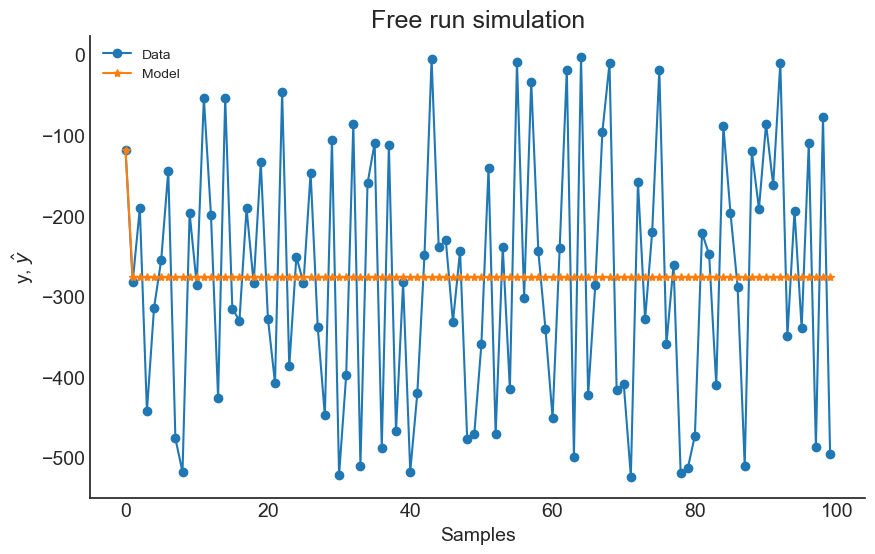

In [4]:

yhat = model.predict(X=x_val, y=y_val)
rrse = root_relative_squared_error(y_val, yhat)


print('Polynomial degree: '+str(deg))
print('Input lags: '+str(xlags[0]))
print('Output lags: '+str(ylags))
print('RRSE: '+str(round(rrse,3)))
print(' ')

r = pd.DataFrame(
    results(
        model.final_model, model.theta, model.err,
        model.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
print(r)
plot_results(y=y_val[0:100], yhat=yhat[0:100], n=1000)


### Non-Linear Autoregressive exogenous inputs (NARX) model

#### Cat Boost Regressor

MSE:  23859.061310376994


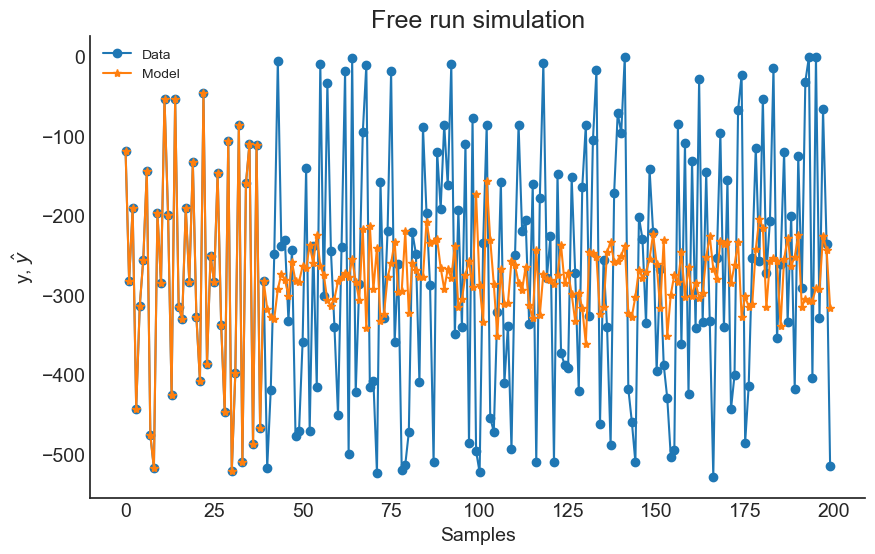

In [8]:
from sysidentpy.general_estimators import NARX
basis_function = Fourier(degree=1)

catboost_narx = NARX(
    base_estimator=CatBoostRegressor(
        iterations=300,
        learning_rate=0.1,
        depth=8
        ),
    xlag=1,
    ylag=40,
    basis_function=basis_function,
    model_type="NARMAX",
    fit_params={'verbose': False}
)

catboost_narx.fit(X=x_id, y=y_id)
yhat = catboost_narx.predict(X=x_val, y=y_val, steps_ahead=1)
print("MSE: ", mean_squared_error(y_val, yhat))
plot_results(y=y_val, yhat=yhat, n=200)


In [ ]:
ee = compute_residues_autocorrelation(y_valid, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
x1e = compute_cross_correlation(y_valid, yhat, x_valid)
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

#### Gradient Boosting Regressor

52971.23533177378


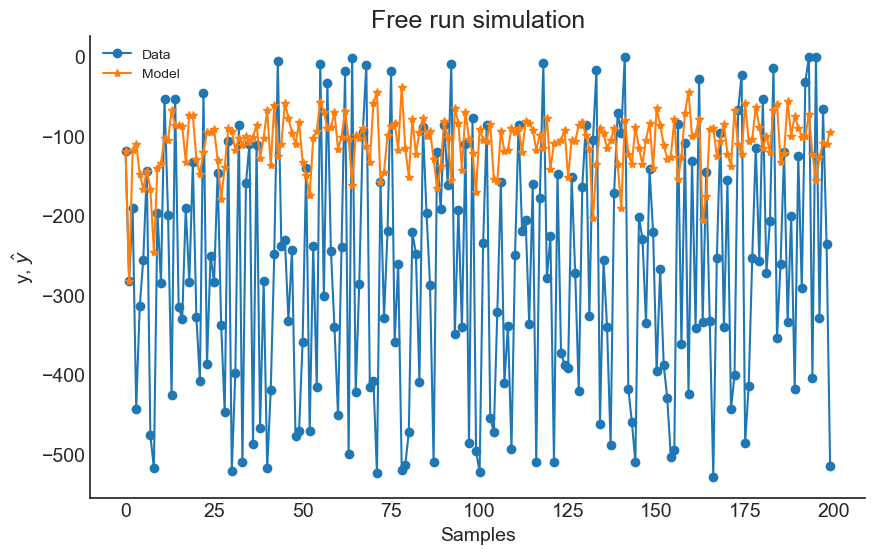

In [10]:
basis_function = Fourier(degree=1)

gb_narx = NARX(
    base_estimator=GradientBoostingRegressor(
        loss='quantile',
        alpha=0.90,
        n_estimators=250,
        max_depth=10,
        learning_rate=.1,
        min_samples_leaf=9,
        min_samples_split=9
        ),
    xlag=2,
    ylag=2,
    basis_function=basis_function,
    model_type="NARMAX"    
)

gb_narx.fit(X=x_id, y=y_id)
yhat = gb_narx.predict(X=x_val, y=y_val)
print(mean_squared_error(y_val, yhat))

plot_results(y=y_val, yhat=yhat, n=200)